## <span style="color:red">ML - DBSCAN</span>

## Import Libraries

In [101]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [76]:
df_football = pd.read_csv("final_data.csv")

In [77]:
df_football.shape

(10754, 22)

In [78]:
df_football.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [79]:
# uniqeness
df_football.drop_duplicates(inplace=True)
df_football[df_football.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [80]:
# Completeness
df_football.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [81]:
# Accurecy types
df_football.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [82]:

df_football.drop("player", axis=1, inplace=True)
#df_football.drop("team", axis=1, inplace=True)
df_football.drop("position", axis=1, inplace=True)
df_football.drop("name", axis=1, inplace=True)

In [83]:
df_football.head(2)

,team,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,Manchester United,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


In [84]:
# Convert categorical variables using OneHotEncoding
categorical_features = ['team'] #

numeric_features = ['height', 'age', 'appearance','goals', 'assists', 'yellow cards',
                    'second yellow cards','red cards', 'goals conceded','clean sheets',
                    'naminutes played', 'days_injured','games_injured', 'award',
                    'current_value',"highest_value","position_encoded"
                    "winger"]

In [85]:
for i in categorical_features:
    print (df_football[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64


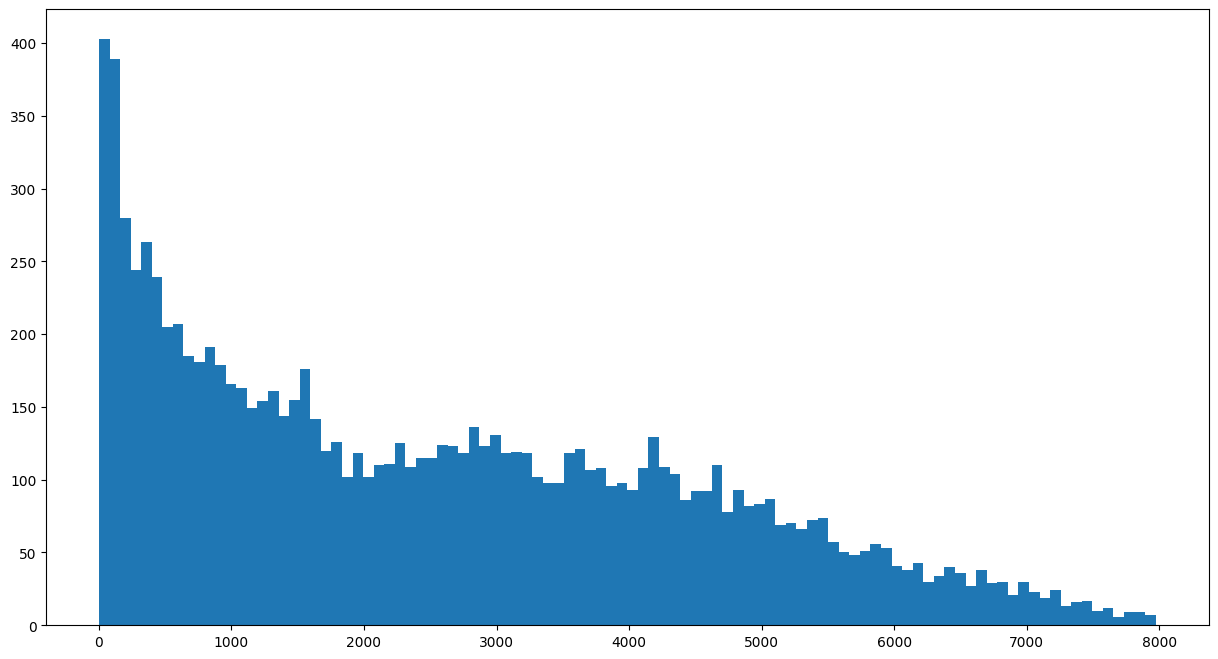

In [86]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['minutes played']);
plt.hist(df_football[(df_football['minutes played']<=8000) & (df_football['minutes played']>0)]['minutes played'],bins=100);


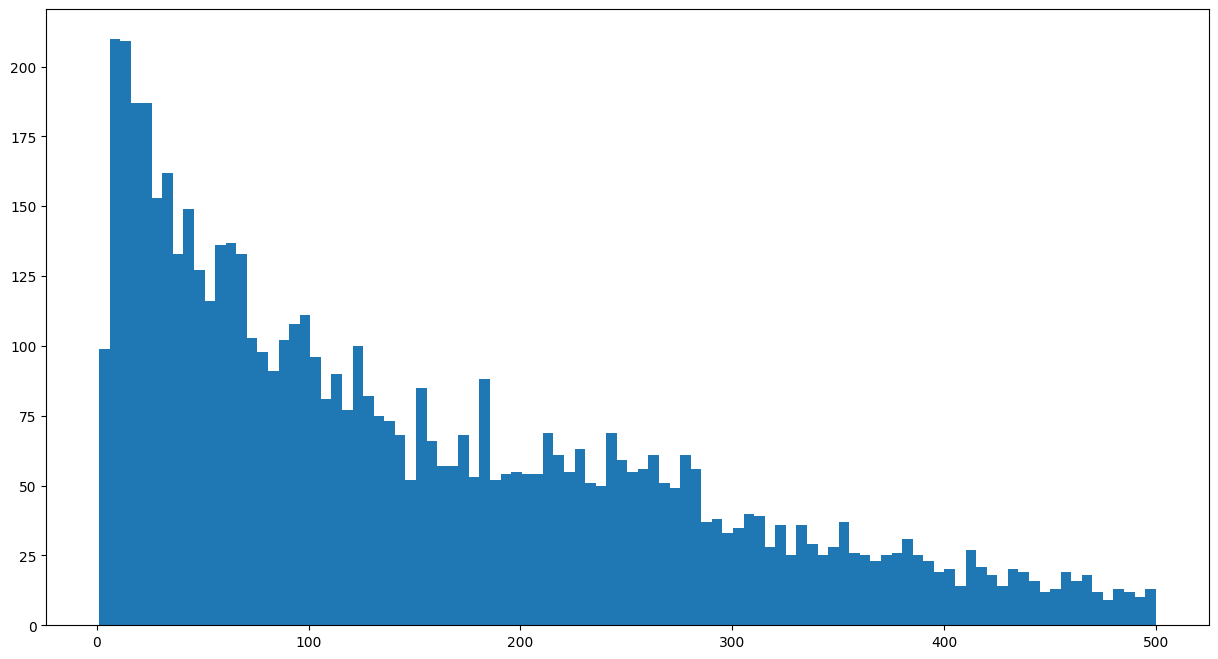

In [87]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['days_injured']);
plt.hist(df_football[(df_football['days_injured']<=500) & (df_football['days_injured']>0)]['days_injured'],bins=100);


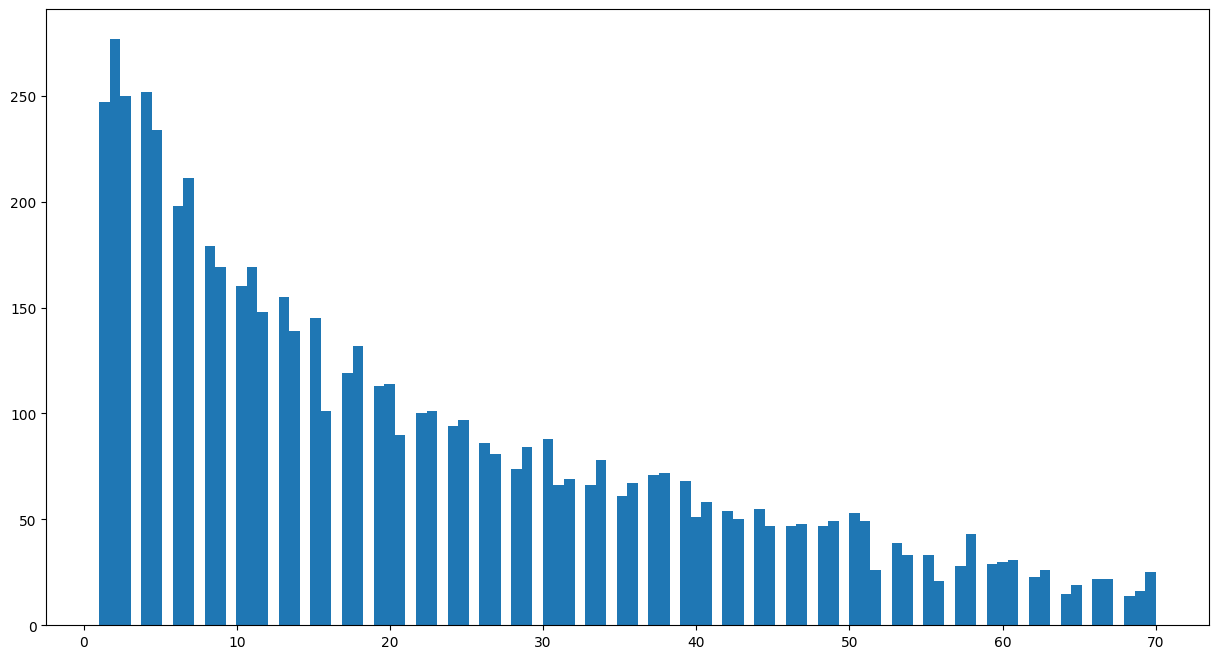

In [88]:

plt.figure(figsize=(15,8))
#plt.boxplot(df_football['games_injured']);
plt.hist(df_football[(df_football['games_injured']<=70) & (df_football['games_injured']>0)]['games_injured'],bins=100);


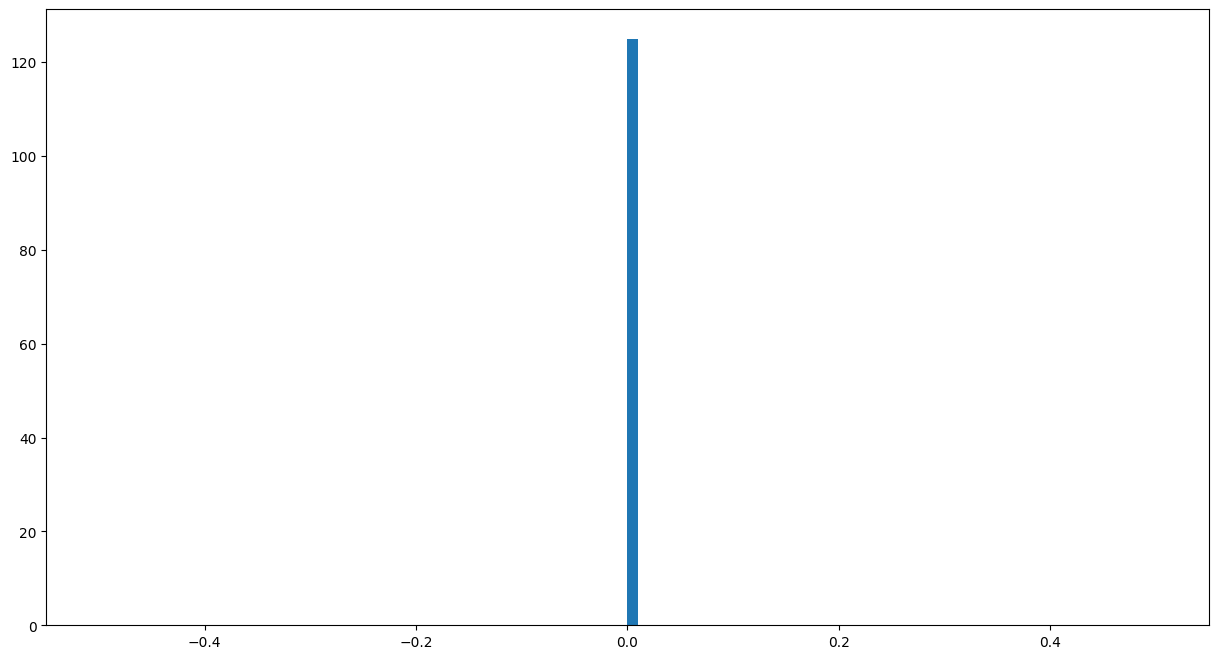

In [89]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['highest_value']);
plt.hist(df_football[(df_football['highest_value']<=0.30) & (df_football['highest_value']>-0.01)]['highest_value'],bins=100);


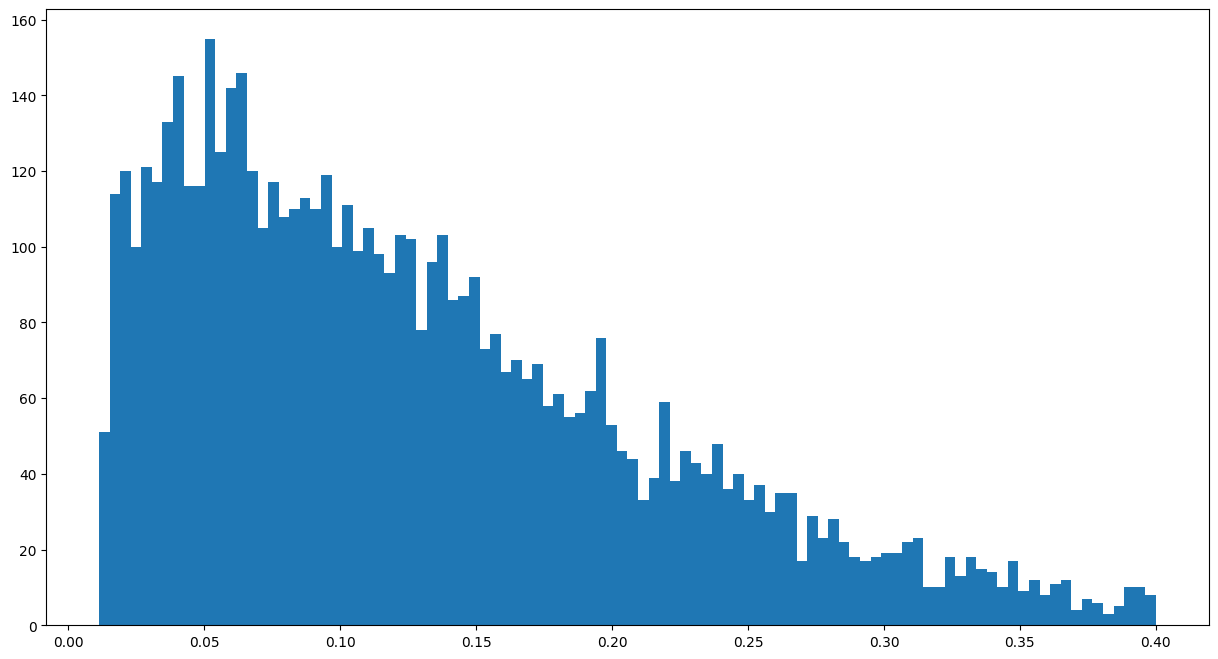

In [90]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['assists']);
plt.hist(df_football[(df_football['assists']<=0.4) & (df_football['assists']>0.0)]['assists'],bins=100);


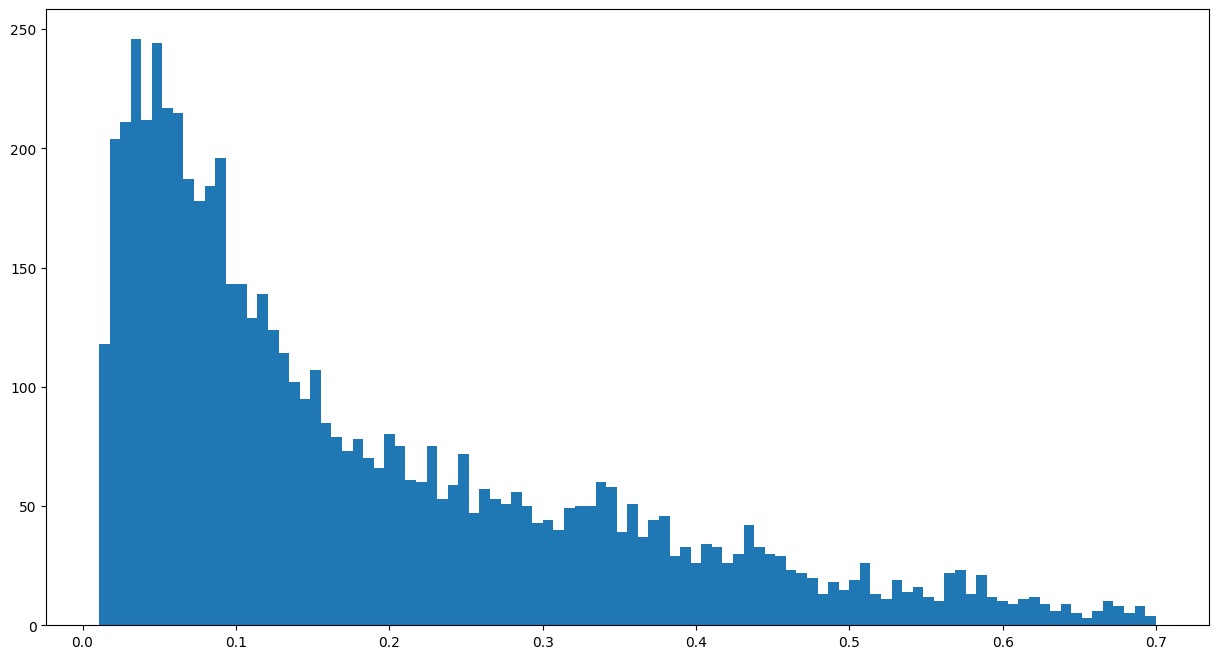

In [91]:
plt.figure(figsize=(15,8))
#plt.boxplot(df_football['goals'])
plt.hist(df_football[(df_football['goals']<0.7) & (df_football['goals']>0)]['goals'], bins=100);

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [92]:
df_football.head(2)

,team,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,189.0,32.0,104,0.0,0.0,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,Manchester United,196.0,30.0,15,0.0,0.0,0.069018,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


#### 3. Feature selection

In [93]:
df_football = df_football[['appearance', 'winger', 'goals', 'yellow cards']]

In [94]:
df_football

,appearance,winger,goals,yellow cards
0,104,0,0.000000,0.009585
1,15,0,0.000000,0.069018
2,4,0,0.000000,0.000000
3,82,0,0.028090,0.224719
4,63,0,0.017889,0.053667
...,...,...,...,...
10749,16,1,0.175953,0.263930
10750,26,0,0.372671,0.186335
10751,20,0,0.375000,0.187500
10752,17,0,0.312139,0.000000


In [95]:
df_football = pd.get_dummies(df_football, columns=['winger'])

In [96]:
df_football

,appearance,goals,yellow cards,winger_0,winger_1
0,104,0.000000,0.009585,True,False
1,15,0.000000,0.069018,True,False
2,4,0.000000,0.000000,True,False
3,82,0.028090,0.224719,True,False
4,63,0.017889,0.053667,True,False
...,...,...,...,...,...
10749,16,0.175953,0.263930,False,True
10750,26,0.372671,0.186335,True,False
10751,20,0.375000,0.187500,True,False
10752,17,0.312139,0.000000,True,False


In [97]:
df_football.head(2)

,appearance,goals,yellow cards,winger_0,winger_1
0,104,0.0,0.009585,True,False
1,15,0.0,0.069018,True,False


#### 4. Prepare train and test data

In [98]:
# Prepare data
X = df_football


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Buliding the Model

In [204]:
# Use NearestNeighbors to find the optimal eps
min_samples = 4

In [205]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [206]:
distances[:,min_samples-1]

array([0.13623562, 0.00543921, 0.        , ..., 0.1237009 , 0.06202375,
       0.03773805])

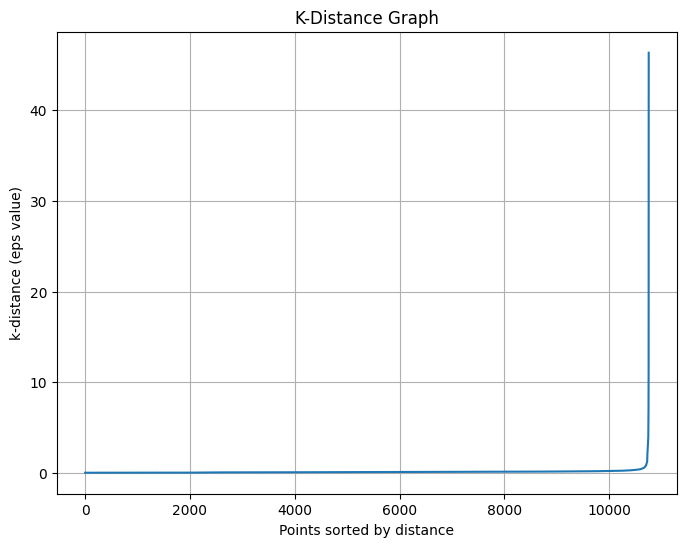

In [207]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [213]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = 1 # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

### Train the Model

In [214]:
# Fit the model on the training data

clusters = dbscan.fit_predict(X_scaled)

In [215]:
pd.Series(clusters).value_counts()

 0    7432
 1    3286
-1      36
Name: count, dtype: int64

## Evaluating the Model

In [217]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

-0.2557494154439227

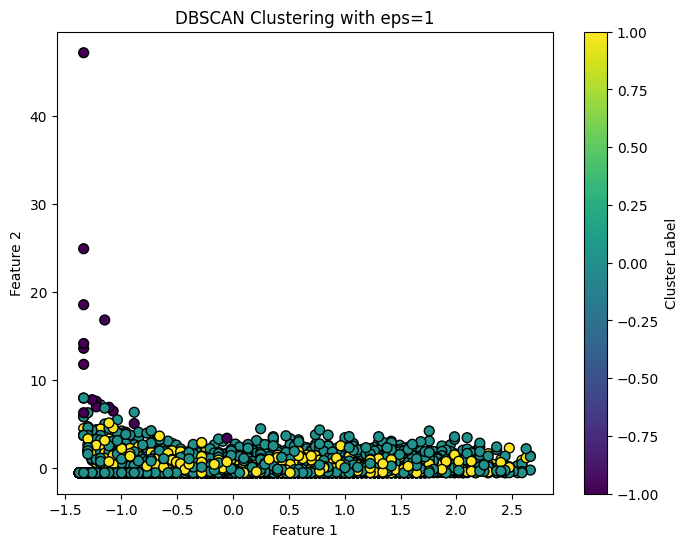

In [220]:
# Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [118]:
X['dbscan'] = clusters

In [119]:
X['dbscan'].value_counts()

dbscan
 0    7432
 1    3297
-1      14
 3       3
 2       2
 4       2
 5       2
 6       2
Name: count, dtype: int64

<Axes: xlabel='yellow cards', ylabel='goals'>

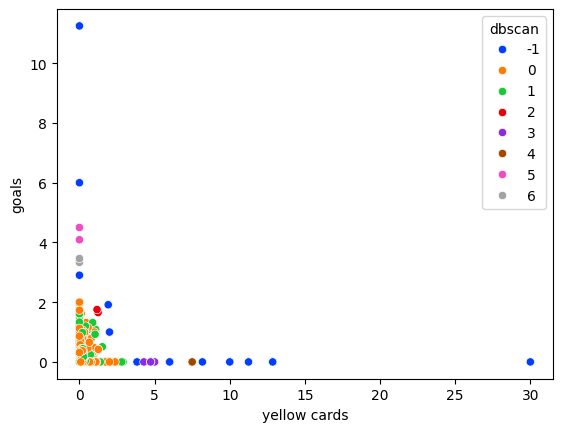

In [218]:
sns.scatterplot(data = X , x = 'yellow cards', y = 'goals', hue = 'dbscan',palette='bright')

<Axes: xlabel='goals', ylabel='appearance'>

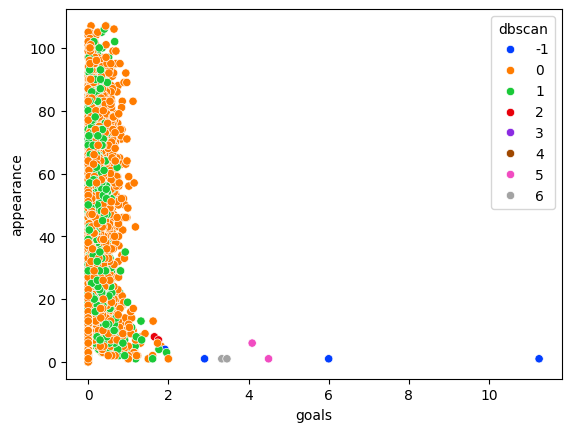

In [219]:
sns.scatterplot(data = X , x = 'goals', y = 'appearance', hue = 'dbscan',palette='bright')